<a href="https://colab.research.google.com/github/KrishnaSChavan/MachineLearning/blob/main/truck_and_car_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google. colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnaschavan","key":"6f1c6fc054fb8d6259f3b6411ea6191e"}'}

In [8]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
!cp kaggle.json ~/.kaggle/

In [10]:
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d ryanholbrook/car-or-truck

 84% 65.0M/77.7M [00:01<00:00, 80.1MB/s]
100% 77.7M/77.7M [00:01<00:00, 67.4MB/s]


In [12]:
import zipfile
zip_r = zipfile.ZipFile('car-or-truck.zip')
zip_r.extractall()
zip_r.close()

In [17]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential,layers
import pathlib
import datetime

In [15]:
for dirpath,dirname,filename in os.walk('car_truck'):
  print(f"There are {dirname} directories and {len(filename)} images in '{dirpath}'.")

There are ['valid', 'train'] directories and 0 images in 'car_truck'.
There are ['Car', 'Truck'] directories and 0 images in 'car_truck/valid'.
There are [] directories and 2922 images in 'car_truck/valid/Car'.
There are [] directories and 2129 images in 'car_truck/valid/Truck'.
There are ['Car', 'Truck'] directories and 0 images in 'car_truck/train'.
There are [] directories and 2961 images in 'car_truck/train/Car'.
There are [] directories and 2156 images in 'car_truck/train/Truck'.


In [51]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "/content/car_truck/train"
test_dir = "/content/car_truck/valid"

train_datagen = ImageDataGenerator(rescale=(1/255.))
test_datagen = ImageDataGenerator(rescale=(1/255.))

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 5117 images belonging to 2 classes.
Found 5051 images belonging to 2 classes.


In [19]:
def callback_tb(dir_name,exp_name):
    log_dir = dir_name+'/'+exp_name+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    return tb_callback

In [24]:
effnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/classification/4"

In [53]:
def create_model(model_url,cla=2):
    feature_extraction = hub.KerasLayer(model_url, trainable=False, name="feature_extraction", input_shape=IMAGE_SHAPE+(3,))

    model = Sequential([
        feature_extraction,
        Dense(cla,activation = "softmax",name='op')
    ])
    
    return model

In [23]:
effnet_model = create_model(effnet_url)
resnet_model = create_model(resnet_url)

inception_model = create_model(inception_v3)

In [54]:
inception_model.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(),
    metrics = ['accuracy']
)

resnet_model.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(),
    metrics = ['accuracy']
)
effnet_model.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(),
    metrics = ['accuracy']
)

In [55]:
resnet_history = resnet_model.fit(
    train_data,
    epochs = 6,
    steps_per_epoch= len(train_data),
    validation_data=test_data,
    validation_steps = len(test_data),
    callbacks=[callback_tb(dir_name='tensorflow_hub',exp_name='resnet')]
)

Epoch 1/6
160/160 [==============================] - 31s 185ms/step - loss: 1.0276 - accuracy: 0.5000 - val_loss: 0.7625 - val_accuracy: 0.5000
Epoch 2/6
160/160 [==============================] - 29s 181ms/step - loss: 0.7399 - accuracy: 0.5000 - val_loss: 0.7187 - val_accuracy: 0.5000
Epoch 3/6
160/160 [==============================] - 29s 180ms/step - loss: 0.7135 - accuracy: 0.5000 - val_loss: 0.7077 - val_accuracy: 0.5000
Epoch 4/6
160/160 [==============================] - 29s 179ms/step - loss: 0.7047 - accuracy: 0.5000 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 5/6
160/160 [==============================] - 29s 180ms/step - loss: 0.7008 - accuracy: 0.5000 - val_loss: 0.7000 - val_accuracy: 0.5000
Epoch 6/6
160/160 [==============================] - 29s 180ms/step - loss: 0.6981 - accuracy: 0.5000 - val_loss: 0.6978 - val_accuracy: 0.5000


<Axes: >

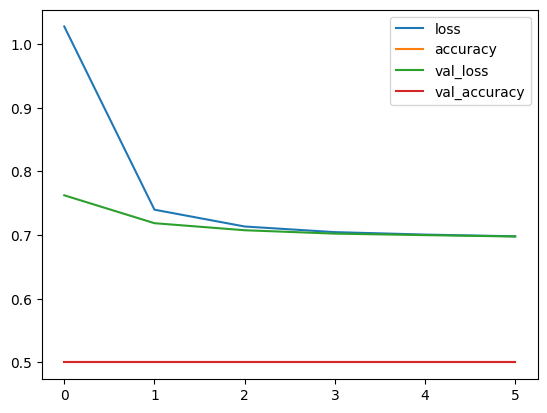

In [56]:
pd.DataFrame(resnet_history.history).plot()

In [ ]:
effnet_history = effnet_model.fit(
    train_data,
    epochs = 5,
    steps_per_epoch= len(train_data),
    validation_data=test_data,
    validation_steps = len(test_data),
    callbacks=[callback_tb(dir_name='tensorflow_hub',exp_name='effnet')]
)

Epoch 1/5
160/160 [==============================] - 34s 146ms/step - loss: 0.3534 - accuracy: 0.8591 - val_loss: 0.2502 - val_accuracy: 0.9042
Epoch 2/5
160/160 [==============================] - 20s 128ms/step - loss: 0.2289 - accuracy: 0.9146 - val_loss: 0.2149 - val_accuracy: 0.9172
Epoch 3/5
160/160 [==============================] - 20s 128ms/step - loss: 0.2011 - accuracy: 0.9242 - val_loss: 0.2002 - val_accuracy: 0.9228
Epoch 4/5
160/160 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9310

In [ ]:
pd.DataFrame(effnet_history.history).plot()

In [ ]:
inception_history = inception_model.fit(
    train_data,
    epochs = 5,
    steps_per_epoch= len(train_data),
    validation_data=test_data,
    validation_steps = len(test_data),
    callbacks=[callback_tb(dir_name='tensorflow_hub',exp_name='inceptionV3')]
)

In [ ]:
pd.DataFrame(inception_history.history).plot()

In [ ]:
!tensorboard dev upload --logdir /content/tensorflow_hub/ \
--name "comp" \
--description "Compair" \
--one_shot